In [2]:
import mst_mach_tools as mmt
from importlib import reload
reload(mmt)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import MDSplus as mds
import pandas as pd
import numpy as np
import numpy.linalg as nl

In [ ]:
shot_file = "/home/reksoatr/canonical_vorticity_probe/tetra/tetrahedral prototype commissioning - 2022-09 - shot settings.xlsx"
compressed_shot_settings = pd.read_excel(shot_file, skiprows=2, header=0)
shot_settings = []
for i, shot in enumerate(compressed_shot_settings['Shots']): 
    if str(shot) == 'nan':
        continue
    if '-' not in shot:
        shot_settings.append(compressed_shot_settings.iloc[i].to_dict())
    if '-' in shot:
        shot_start, shot_end = shot.split('-')
        date = shot_start[:-3]
        start = shot_start[-3:]
        for j in range(int(start), int(shot_end) + 1):
            shot_to_save = date + str(j).zfill(3)
            settings = compressed_shot_settings.iloc[i].to_dict()
            settings['Shots'] = shot_to_save
            shot_settings.append(settings)
shot_settings = pd.DataFrame(shot_settings)

In [ ]:
shot_settings

In [ ]:
shot_settings.keys()

In [ ]:
shot_settings[shot_settings['Shots'] == '1220927038']['RJ2  (Ohm)'].values[0]

In [ ]:
"START 'mach_results' METHOD PROCESS"

import mst_mach_tools as mmt
import matplotlib.pyplot as plt
import numpy as np

shot='1220927056'
nsmooth=51
res='mach'
delphi=-60.0
tmin=-0.001
tmax=0.07
comp='toni'
vtype='tetrahedron'
imin=5E-4
k=1.1
second_shot='1220927038'
tetra_missing_tip=4
mds_start='probe5_'
merge_method='first'

RJkeys=['RJ1 (Ohm)','RJ2  (Ohm)','RJ3  (Ohm)','RJ4  (Ohm)','RJ return']

rj_set=[]
rj_set2 =[]

for RJ in RJkeys:
    rj_set.append(shot_settings[shot_settings['Shots'] == shot][RJ].values[0])
    rj_set2.append(shot_settings[shot_settings['Shots'] == second_shot][RJ].values[0])
rj_set[3] =  20
rj_set2[3] = 20

rj_set, rj_set2

In [ ]:
isat = {}
time = {}
isat2 = {}
time2 = {}
if vtype.startswith('octa'):
    tip_abc_name = ['a', 'b', 'c', 'd', 'e', 'f', 'ret']
    tip_num_name = ['1', '4', '5', '2', '3', '6', '7']
if vtype.startswith('tetra'):
    tip_abc_name = ['a', 'b', 'c', 'd', 'ret']
    #second_tip_abc_name = ['b', 'a', 'd', 'c', 'ret']
    tip_num_name = ['4', '1', '3', '2', '5']
    tip_num_name2 = ['3', '2', '4', '1', '5']

In [ ]:
rj = dict(zip(tip_abc_name,
     rj_set))
rj2 = dict(zip(tip_abc_name,
      rj_set2))
tip_mds_name = [mds_start + str(n).zfill(2) for n in \
    tip_num_name]   
tip_mds_name2 = [mds_start + str(n).zfill(2) for n in \
    tip_num_name2]
mst_name = ['theta', 'phi', 'r']  # ['x', 'y', 'z'] in Cartesian
rj, rj2, tip_mds_name, tip_mds_name2

In [ ]:
for i in range(len(tip_abc_name)):
    abc = tip_abc_name[i]
    time[abc], isat[abc] = mmt.get_data(name=tip_mds_name[i], shot=int(shot),
        comp=comp, tmin=tmin, tmax=tmax)
    #
    # if second_shot assume it is with probe rotated by 180 degrees
    if second_shot:
        time2[abc], isat2[abc] = mmt.get_data(name=tip_mds_name2[i], shot=int(second_shot),
                                          comp=comp, tmin=tmin, tmax=tmax)

        if nsmooth is not None:
            isat2[abc] = mmt.smooth(isat2[abc], nsmooth)
        isat2[abc] /= rj2[abc]
        isat2[abc] = np.maximum(isat2[abc], imin)

    if nsmooth is not None:
        isat[abc] = mmt.smooth(isat[abc], nsmooth)
    isat[abc] /= rj[abc]
    isat[abc] = np.maximum(isat[abc], imin)

print(isat)
print(isat2)
    
if second_shot:
    time, isat = mmt.merge_shots(time, time2, isat, isat2,
                             tip_abc_name[tip_num_name.index(str(4))],
                             tip_abc_name[tip_num_name2.index(str(4))],
                             merge_method="first")

    if merge_method == 'second':
        tip_num_name = tip_num_name2

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(50, 30))
axes[0].plot(isat["a"])
axes[1].plot(isat["b"])
axes[2].plot(isat["c"])
axes[3].plot(isat["d"])
axes[4].plot(isat["ret"])

In [ ]:
for i in range(len(tip_abc_name)):
    abc = tip_abc_name[i]
    if abc == 'a':
        isat['sum'] = np.zeros(np.shape(isat['a']))
    if abc != 'ret':
        isat['sum'] += isat[abc]
        
plt.figure(figsize=(50,10))
plt.plot(isat['sum'])

In [ ]:
time_arrays_equal = True
for name in tip_abc_name[1:]:
    if np.array_equal(time['a'], time[name]):
        continue
    time_arrays_equal = False
if (time_arrays_equal):
    time = time['a']
else:
    print('Time arrays not all equal')
    #return None

In [ ]:
if res.lower().startswith('isat'):
    isat['t'] = time
    isat['name'] = dict(zip(tip_num_name, tip_abc_name))
    isat['rj'] = rj
    isat['units'] = 'A'
    #return isat
if vtype.startswith('octa'):
    ratio = np.array((isat['a']/isat['d'], isat['b']/isat['e'],
        isat['c']/isat['f']))
    rat_name = ['a/d', 'b/e', 'c/f']
elif vtype.startswith('tetra'):        
    ratio = np.array((isat['a']*isat['b']/isat['c']/isat['d'],
        isat['b']*isat['c']/isat['d']/isat['a'],
        isat['c']*isat['a']/isat['b']/isat['d']))
    rat_name = ['a*b/c/d', 'b*c/d/a', 'c*a/b/d']
    
ratio

In [ ]:
ratio.shape

In [ ]:
if res.startswith('rat'):
    Output= {'rat':ratio, 't':time, 'name':rat_name, 'units':None}
log = - 1.0/k*np.log(ratio)
log

In [ ]:
if res.startswith('log'):
    Output= {'log':log, 't':time, 'name':rat_name, 'units':None}
mat = mmt.angle_matrix(vtype=vtype, rz=delphi)
mat

In [ ]:
if res.startswith('mat'):
    Output= {'mat':mat, 'mst_name':mst_name, 'ratio_name':rat_name}
inv = nl.inv(mat)
inv

In [ ]:
if res.startswith('inv'):
    Output= {'inv':inv, 'mst_name':mst_name, 'ratio_name':rat_name}
vel = np.dot(inv, log)
vel

In [ ]:
if res.startswith('mach'):
    Output= {'t':time, 'r':vel[mst_name.index('r')],
        'theta':vel[mst_name.index('theta')],
        'phi':vel[mst_name.index('phi')], 'units':'M'}
Output

In [ ]:
mst_name

In [ ]:
fig1,ax1=plt.subplots(3,1,figsize=(50,30))
ax1[0].plot(Output['t'],Output['r'])
ax1[1].plot(Output['t'],Output['theta'])
ax1[2].plot(Output['t'],Output['phi'])

rj {'a': 20, 'b': 20, 'c': 20, 'd': 20, 'ret': 5}
tip_mds_name ['probe5_04', 'probe5_01', 'probe5_03', 'probe5_02', 'probe5_05']


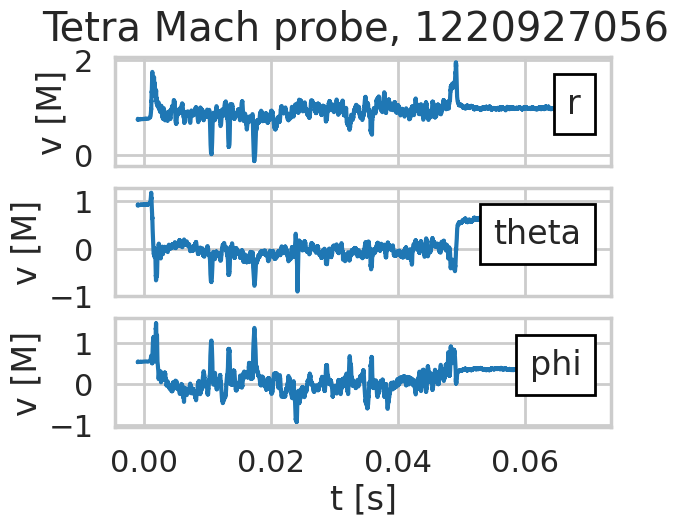

In [4]:
mmt.plot_mach_results(shot=1220927056,second_shot=1220927038,nsmooth=51,rj_set2=[20,20,20,20,5])

rj {'a': 10, 'b': 10, 'c': 10, 'd': 10, 'ret': 10}
tip_mds_name ['probe2_04', 'probe2_01', 'probe2_03', 'probe2_02', 'probe2_05']


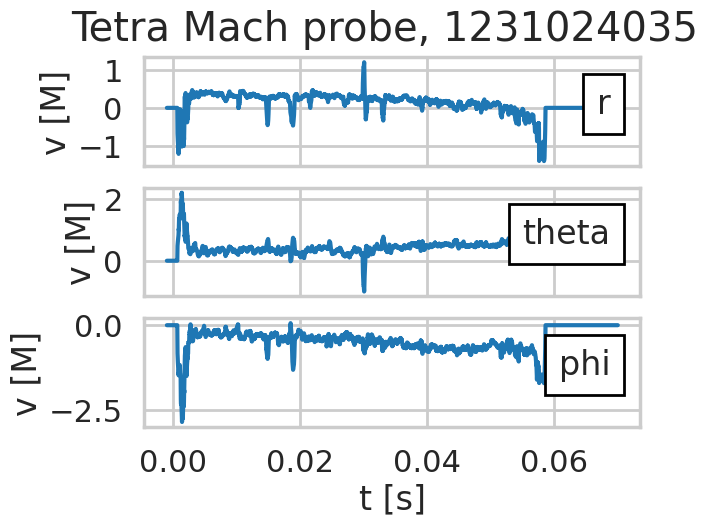

In [5]:
mmt.plot_mach_results(shot=1231024035,rj_set=[10,10,10,10,10],tip_num_name = ['1', '4', '2', '3', '5'],tetra_missing_tip=None,second_shot=None,mds_start='probe2_')